<a href="https://colab.research.google.com/github/weiyuchen1213/Active-Learning/blob/master/Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install modAL

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {'username':'weiyuchen77','key':'2f37118812a2fab44b6a6853616f9fa7'}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle config set -n path -v{/content}

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aungpyaeap/fish-market
!kaggle datasets download -d uciml/mushroom-classification
!kaggle datasets download -d uciml/iris

In [ ]:
!unzip fish-market.zip
!unzip mushroom-classification.zip
!unzip iris.zip

In [254]:
import pandas as pd
fish = pd.read_csv('Fish.csv')
mushroom = pd.read_csv('mushrooms.csv')
iris = pd.read_csv('Iris.csv')
iris = iris.drop('Id',axis=1)

https://stackoverflow.com/questions/34915813/convert-text-columns-into-numbers-in-sklearn

https://www.w3resource.com/machine-learning/scikit-learn/iris/python-machine-learning-k-nearest-neighbors-algorithm-exercise-3.php


In [255]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
iris.Species = le.fit_transform(iris.Species)
fish.Species = le.fit_transform(fish.Species)

mushroom = mushroom[mushroom.columns[:]].apply(le.fit_transform)


In [260]:
fish

,Species,Weight,Length1,Length2,Length3,Height,Width
0,0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,0,290.0,24.0,26.3,31.2,12.4800,4.3056
2,0,340.0,23.9,26.5,31.1,12.3778,4.6961
3,0,363.0,26.3,29.0,33.5,12.7300,4.4555
4,0,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,5,12.2,11.5,12.2,13.4,2.0904,1.3936
155,5,13.4,11.7,12.4,13.5,2.4300,1.2690
156,5,12.2,12.1,13.0,13.8,2.2770,1.2558
157,5,19.7,13.2,14.3,15.2,2.8728,2.0672


In [264]:
# fish
X_fish = fish.drop('Species', axis=1)
y_fish = fish['Species']

#mushrooms
X_mushroom = mushroom.drop('class', axis=1)
y_mushroom = mushroom['class']

# iris
X_iris = iris.drop('Species', axis=1)
y_iris = iris['Species']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5])

In [216]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

In [217]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [218]:
from sklearn.datasets import load_iris

#iris = load_iris()
X_raw = X_iris.values
y_raw = y_iris.values
#iris

In [219]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

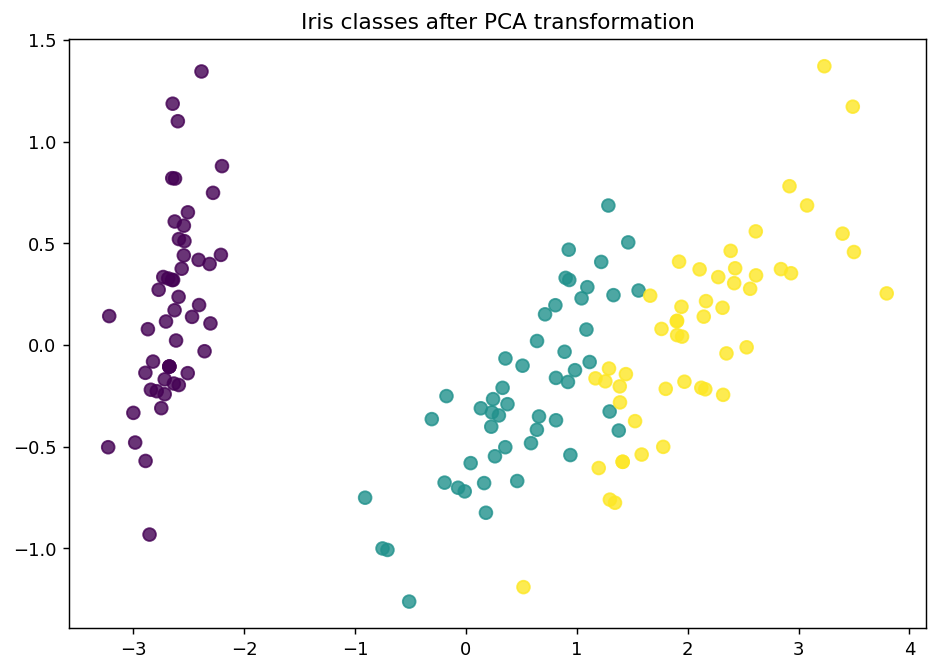

In [220]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

In [221]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [222]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [223]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

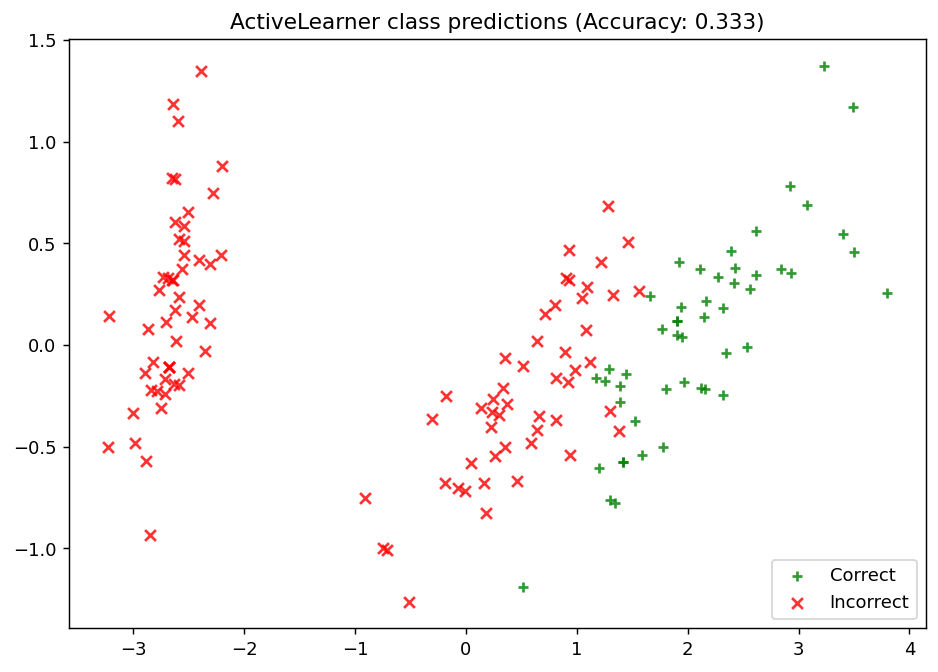

In [224]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [225]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267


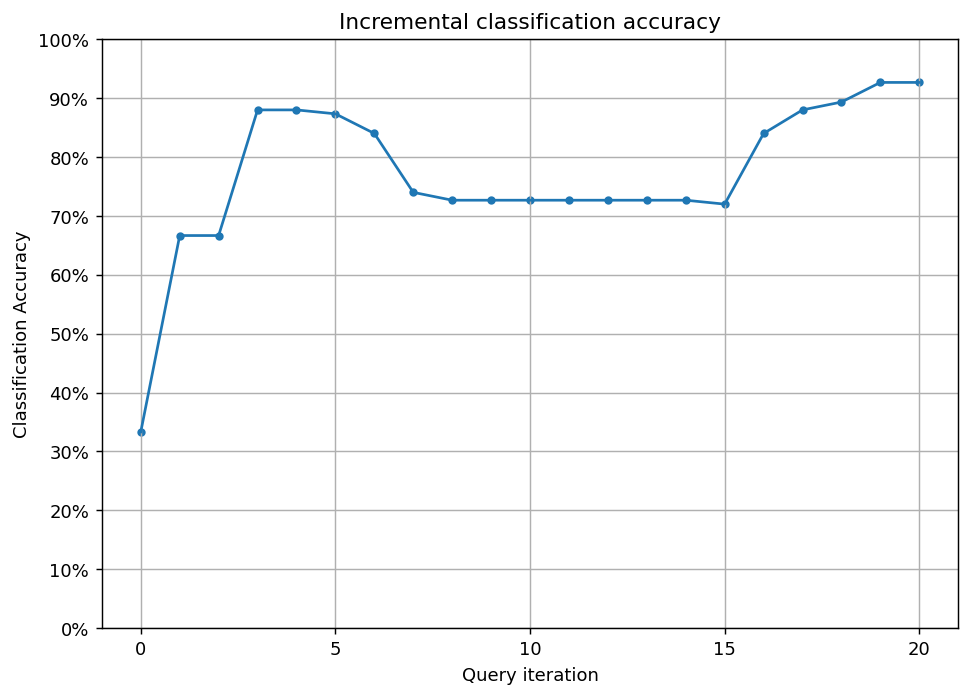

In [226]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

In [232]:
from modAL.models import  ActiveLearner, BayesianOptimizer, Committee, CommitteeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

X_train, y_train = load_iris().data, load_iris().target

learner = BayesianOptimizer(estimator=RandomForestClassifier())
scores = cross_val_score(learner, X_train, y_train, cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/pytho

In [233]:
scores

array([1.        , 1.        , 1.        , 1.        , 0.93333333,
       0.86666667, 1.        , 0.86666667, 0.8       , 1.        ])